In [1]:
import numpy as np
import cv2
import pytesseract
import pandas as pd
from shapely import geometry
import matplotlib as mpl
import matplotlib.pyplot as plt
import os


# Load Screenshots

In [ ]:
areas = []
num_files = int(len(os.listdir('data/protected_areas'))/2)
for i in range(num_files):
    try:
        img_1 = cv2.imread(f'data/protected_areas/protected_area_{i}_tl.png')
        img_2 = cv2.imread(f'data/protected_areas/protected_area_{i}_br.png')
        areas.append((img_1, img_2))
    except:
        continue

print(len(areas))


# Get the silhouettes of each protected area

In [2]:
def get_coords(img, tl: tuple, br: tuple):
    img_1 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    for i in range(len(img_1)):
        for j in range(len(img_1[0])):
            if i <= 80 and j <= 250:
                img_1[i][j] = [0,0,0]
            if img_1[i][j][1] < 100:
                img_1[i][j] = [0,0,0]
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_HSV2BGR)
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    for i in range(50):
        for j in range(150):
            img_1[i][j] = 0

    for i in range(1600, len(img_1)):
        for j in range(120):
            img_1[i][j] = 0

    # # Binarize the image
    _, binary = cv2.threshold(img_1, 100, 200, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tlx, tly = tl
    brx, bry = br
    h = abs(bry - tly)/len(img_1)
    w = abs(brx - tlx)/len(img_1[0])
    # Extract polygons from contours
    polygons = set()
    for contour in contours:
        # Convert contour to a list of (x, y) coordinates
        points = [(tlx + w* point[0][0], tly - h * point[0][1]) for point in contour]
        # Create a Shapely Polygon object
        # for point in points:
        #     plt.scatter(point[0], point[1])
        try:
            polygon = geometry.Polygon(points)
            polygons.add(polygon)
        except:
            continue
    return polygons
    

In [32]:
def get_concession(i):
    img_ext = cv2.imread(f'/Users/visal/Documents/indonesia-deforestation/data/protected_areas_2/protected_area_{i}_br.png')
    img_ext_2 = cv2.imread(f'/Users/visal/Documents/indonesia-deforestation/data/protected_areas_2/protected_area_{i}_tl.png')
    img_read_br = cv2.cvtColor(img_ext, cv2.COLOR_BGR2GRAY)
    img_read_tl = cv2.cvtColor(img_ext_2, cv2.COLOR_BGR2GRAY)
    _, img_read_br = cv2.threshold(img_read_br, 200, 255, cv2.THRESH_BINARY)
    _, img_read_tl = cv2.threshold(img_read_tl, 200, 255, cv2.THRESH_BINARY)
    img_br = pytesseract.image_to_string(img_read_br[5:35, 15:120]).strip()
    img_tl = pytesseract.image_to_string(img_read_tl[5:35, 15:120]).strip()
    new_br = ''
    new_tl = ''
    has_comma = False
    for i in img_br:
        if i in ['0','1','2','3','4','5','6','7','8','9','-','.']:
            new_br += i
        if i == ',':
            if not has_comma:
                new_br += i
                has_comma = True
            else:
                new_br += '.'
    has_comma = False
    for i in img_tl:
        if i in ['0','1','2','3','4','5','6','7','8','9','-','.']:
            new_tl += i
        if i == ',':
            if not has_comma:
                new_tl += i
                has_comma = True
            else:
                new_tl += '.'
    br_comma = new_br.index(',')
    tl_comma = new_tl.index(',')
    tup_br = (eval(new_br[0:br_comma]),eval(new_br[br_comma+1:]))
    if tup_br[0] > 150:
        tup_br = (eval(new_br[0:br_comma])/1000,eval(new_br[br_comma+1:]))
    elif tup_br[0] < 0:
        tup_br = (abs(eval(new_br[0:br_comma])),eval(new_br[br_comma+1:]))
    tup_tl = (eval(new_tl[0:tl_comma]),eval(new_tl[tl_comma+1:]))
    if tup_tl[0] > 150:
        tup_tl = (eval(new_tl[0:tl_comma])/1000,eval(new_tl[tl_comma+1:]))
    elif tup_tl[0] < 0:
        tup_tl = (abs(eval(new_tl[0:tl_comma])),eval(new_tl[tl_comma+1:]))
    return get_coords(img_ext, tup_tl , tup_br)
    

80 Value out of bounds
113 Value out of bounds
127 Value out of bounds
136 Value out of bounds
145 Value out of bounds
200 substring not found
233 Value out of bounds
238 Value out of bounds
248 Value out of bounds
356
365
389 Value out of bounds
395 Value out of bounds
464
472 substring not found
577 substring not found
579 substring not found
591 Value out of bounds
594 Value out of bounds


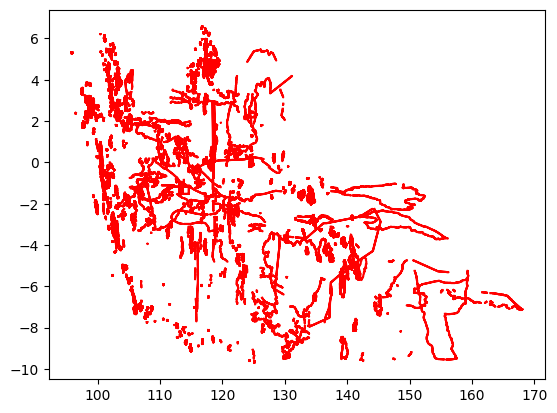

In [ ]:
for j in range(num_files):
    try:
        for i in get_concession(j):
            x,y = i.exterior.xy
            if np.any(np.array(y) < -10):
                raise ValueError("Value out of bounds")
            plt.plot(x, y, c="red")
    except ValueError as v:
        print(j, v)
    except:
        print(j)
plt.show()

In [ ]:
area_coords = []
for j in range(num_files):
    try:
        coords = []
        for i in get_concession(j):
            x,y = i.exterior.xy
            if np.any(np.array(y) < -10):
                raise ValueError("Value out of bounds")
            coords.append(i)
        area_coords.append(geometry.MultiPolygon(coords))
    except ValueError as v:
        print(j, v)
    except:
        print(j)

80 Value out of bounds
113 Value out of bounds
127 Value out of bounds
136 Value out of bounds
145 Value out of bounds
200 substring not found
233 Value out of bounds
238 Value out of bounds
248 Value out of bounds
356
365
389 Value out of bounds
395 Value out of bounds
464
472 substring not found
577 substring not found
579 substring not found
591 Value out of bounds
594 Value out of bounds


# Get 5 km bounds

In [ ]:
from scipy.spatial import ConvexHull as ch
x = []
y = []
for polygon in area_coords[0].geoms:
    x.extend(polygon.exterior.xy[:][0])
    y.extend(polygon.exterior.xy[:][1])
print(len(x),len(y))
print(ch([x,y]))

4110 4110


QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4111)

While executing:  | qhull i Qx Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 622708950  incidence  Qxact-merge  Qtriangulate  _zero-centrum
  Q3-no-merge-vertices-dim-high  _maxoutside  0


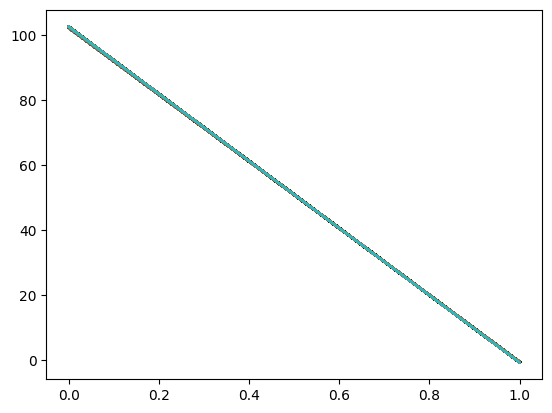

In [ ]:
for polygon in area_coords[0].geoms:
    plt.plot(polygon.exterior.xy)
plt.show()

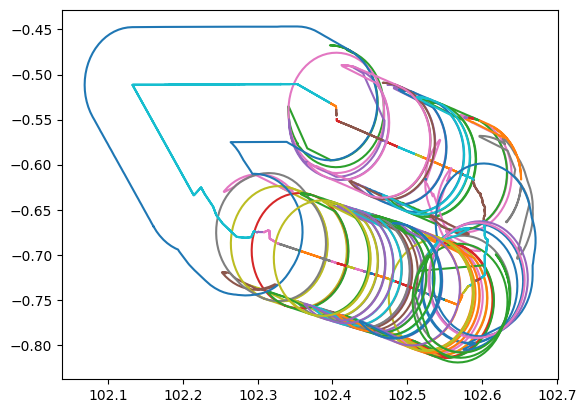

In [ ]:
for j in range(0,1):
    #try:
    coords = []
    for i in get_concession(j):
        x,y = i.exterior.xy
        for k in range(len(x)):
            coords.append((y[k],x[k]))
        plt.plot(x,y)
        distance = 0.0639
        if type(i.buffer(distance)) == geometry.Polygon:
            x,y = i.buffer(distance).exterior.xy
            plt.plot(x,y)
        else:
            for k in i.buffer(distance).geoms:
                x,y = k.exterior.xy
                plt.plot(x,y)
    
        
    shp = geometry.Polygon(coords)
    # plt.plot(shp.exterior.xy)
    plt.show()
    #except Exception as v:
    #   print(j, v)

Number of protected areas at least 1000 Ha

In [4]:
lengths = []
for i in range(1363):
    file = cv2.imread(f"/Users/visal/Documents/indonesia-deforestation/data/protected_area_size/protected_area_{i}.png")
    txt = pytesseract.image_to_string(file)[:-3].strip()
    if len(txt) > 8:
        txt = float(txt[:-8] + txt[-7:-4]+txt[-3:])
    elif len(txt) > 3:
        txt = float(txt[:-4]+txt[-3:])
    else:
        txt = float(txt)
    lengths.append(txt)




In [5]:
greater = [(i, lengths[i]) for i in range(len(lengths)) if lengths[i] > 1000]
print(len(greater))
print(greater)

741
[(0, 80578.0), (1, 57710.0), (2, 202788.0), (3, 158468.0), (4, 491483.0), (5, 57946.0), (6, 38675.0), (7, 50281.0), (8, 50281.0), (9, 12324.0), (10, 65910.0), (11, 40157.0), (12, 270735.0), (13, 41611.0), (14, 23280.0), (15, 12951.0), (16, 18277.0), (17, 27086.0), (18, 262939.0), (19, 24416.0), (20, 1088549.0), (21, 29993.0), (22, 96992.0), (23, 276775.0), (24, 39963.0), (25, 17760.0), (26, 210587.0), (27, 89885.0), (28, 58714.0), (29, 114182.0), (30, 202736.0), (31, 2885.0), (32, 99794.0), (33, 200198.0), (34, 101282.0), (35, 122087.0), (36, 816525.0), (37, 325900.0), (38, 28845.0), (39, 15400.0), (40, 48379.0), (41, 13814.0), (42, 50029.0), (43, 828321.0), (44, 89278.0), (45, 65398.0), (46, 5623.0), (47, 140967.0), (48, 177990.0), (49, 90461.0), (50, 93634.0), (51, 146021.0), (52, 31516.0), (53, 11483.0), (54, 92932.0), (55, 37644.0), (56, 118695.0), (57, 174671.0), (58, 51858.0), (59, 8873.0), (60, 356170.0), (61, 83656.0), (62, 38417.0), (63, 36598.0), (64, 528886.0), (65, 3023

In [6]:
import time
import pyautogui
import Quartz.CoreGraphics as Quartz

In [7]:
def scr_one(i):
    pyautogui.moveTo(160,280)
    time.sleep(1)
    pyautogui.click()
    time.sleep(20)
    pyautogui.moveTo(595,205)
    time.sleep(1)
    scrn = pyautogui.screenshot(region=(595,205, 1090, 835))
    scrn.save(f'/Users/visal/Documents/indonesia-deforestation/data/protected_areas_2/protected_area_{i}_tl.png')

def scr_two(i):
    pyautogui.moveTo(1685,1040)
    time.sleep(1)
    scrn = pyautogui.screenshot(region=(595,205, 1090, 835))
    scrn.save(f'/Users/visal/Documents/indonesia-deforestation/data/protected_areas_2/protected_area_{i}_br.png')

def vscroll(clicks, x=None, y=None):
    if x and y:
        pyautogui.moveTo(x,y)
    clicks = int(clicks)
    for _ in range(abs(clicks)):  # <------------------------------------
        scrollWheelEvent = Quartz.CGEventCreateScrollWheelEvent(
            None, # no source
            0, # units  <------------------------------------------------
            1, # wheelCount (number of dimensions)
            1 if clicks >= 0 else -1) # vertical movement <--------------
        Quartz.CGEventPost(Quartz.kCGHIDEventTap, scrollWheelEvent)

def click_num(num, max = 200):
    page = num // 200
    i = num % 200
    pyautogui.moveTo(160,400)
    time.sleep(1)
    pyautogui.click()
    time.sleep(3)
    pyautogui.moveTo(520,595)
    time.sleep(1)
    pyautogui.click()
    time.sleep(5)
    for j in range(page):
        if j == 0:
            pyautogui.moveTo(450,1050)
        else: 
            pyautogui.moveTo(600,1050)
        pyautogui.click()
        time.sleep(2)
    vscroll(-46* min(i,183-(200-max)), 1270,260)

    if i > 183-(200-max):
        pyautogui.moveTo(1270, 255 + 46*(i-183 + (200-max)))

    time.sleep(1)
    pyautogui.click()

In [8]:
def refresh():
    time.sleep(1)
    pyautogui.moveTo(1200,65)
    time.sleep(0.5)
    pyautogui.click()
    time.sleep(5)
    pyautogui.moveTo(60,375)
    time.sleep(0.5)
    pyautogui.click()
    time.sleep(2)
    pyautogui.moveTo(530,395)
    time.sleep(0.5)
    pyautogui.click()
    time.sleep(5)
    pyautogui.moveTo(1040,587)
    time.sleep(1)
    pyautogui.click()
    pyautogui.moveTo(640,140)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #1
    pyautogui.moveTo(490,320)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,345)
    time.sleep(1)
    pyautogui.dragTo(230,345, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,320)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #2
    pyautogui.moveTo(490,390)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,415)
    time.sleep(1)
    pyautogui.dragTo(230,415, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,390)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #3
    pyautogui.moveTo(490,540)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,570)
    time.sleep(1)
    pyautogui.dragTo(230,570, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,540)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #4
    pyautogui.moveTo(490,615)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,640)
    time.sleep(1)
    pyautogui.dragTo(230,640, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,615)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #5
    pyautogui.moveTo(490,825)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,850)
    time.sleep(1)
    pyautogui.dragTo(230,850, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,825)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #Scroll
    pyautogui.vscroll(-20)
    time.sleep(1)
    #6
    pyautogui.moveTo(490,450)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(490,475)
    time.sleep(1)
    pyautogui.dragTo(230,475, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,450)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #7
    pyautogui.moveTo(490,520)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,545)
    time.sleep(1)
    pyautogui.dragTo(230,545, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,520)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #8
    pyautogui.moveTo(490,595)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,620)
    time.sleep(1)
    pyautogui.dragTo(230,620, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,595)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #9
    pyautogui.moveTo(490,665)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,720)
    time.sleep(1)
    pyautogui.dragTo(230,720, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,665)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #10
    pyautogui.moveTo(490,760)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,785)
    time.sleep(1)
    pyautogui.dragTo(230,785, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,760)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #11
    pyautogui.moveTo(490,835)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(550,860)
    time.sleep(1)
    pyautogui.dragTo(230,860, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,835)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #12
    pyautogui.moveTo(490,910)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(425,935)
    time.sleep(1)
    pyautogui.dragTo(230,935, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,910)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #13
    pyautogui.moveTo(490,1020)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    pyautogui.moveTo(395,1045)
    time.sleep(1)
    pyautogui.dragTo(230,1045, button="left")
    time.sleep(1)
    pyautogui.moveTo(490,1020)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
    #deselect
    pyautogui.moveTo(1675,1060)
    time.sleep(1)
    pyautogui.click()
    time.sleep(1)
        

In [114]:
time.sleep(4)
for i in [477,478,479]:
    if i % 20 == 0:
        refresh()
    if i < 1200:
        click_num(i)
    else:
        click_num(i, max=163)
    scr_one(i)
    scr_two(i)

In [9]:
protected_areas = {}

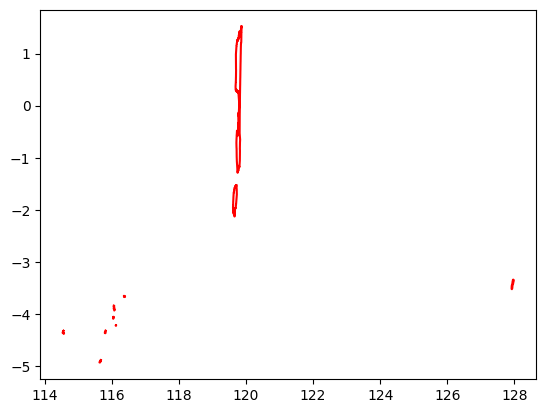

In [ ]:
for j in [477,478,479]:
    try:
        concession = get_concession(j)
        for i in concession:
            x,y = i.exterior.xy
            plt.plot(x, y,c="red")
        #protected_areas[j] = geometry.MultiPolygon(concession)
    except:
        print(j)
    
plt.show()

In [204]:
print(sorted([i for i in protected_areas.keys()], key= lambda x: protected_areas[x].length, reverse=True)[13:20])
# for i in protected_areas.keys():
#     area = protected_areas[i]
#     if area.area 

[103, 8, 366, 18, 3, 44, 189]


98
118.465,6.534 118.371,4.606
(118.465, 6.534) (118.371, 4.606)


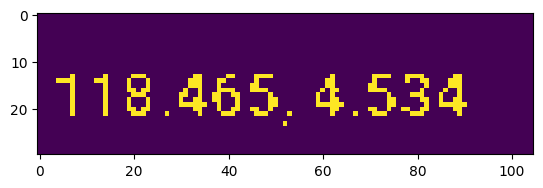

In [252]:
l = sorted([i for i in protected_areas.keys()], key= lambda x: protected_areas[x].length, reverse=True)[30]
print(l)
img_ext = cv2.imread(f'/Users/visal/Documents/indonesia-deforestation/data/protected_areas_2/protected_area_{516}_br.png')
img_ext_2 = cv2.imread(f'/Users/visal/Documents/indonesia-deforestation/data/protected_areas_2/protected_area_{516}_tl.png')
img_read_br = cv2.cvtColor(img_ext, cv2.COLOR_BGR2GRAY)
img_read_tl = cv2.cvtColor(img_ext_2, cv2.COLOR_BGR2GRAY)
_, img_read_br = cv2.threshold(img_read_br, 200, 255, cv2.THRESH_BINARY)
_, img_read_tl = cv2.threshold(img_read_tl, 200, 255, cv2.THRESH_BINARY)
img_br = pytesseract.image_to_string(img_read_br[5:35, 15:120]).strip()
img_tl = pytesseract.image_to_string(img_read_tl[5:35, 15:120]).strip()
plt.imshow(img_read_br[5:35, 15:120])
new_br = ''
new_tl = ''
has_comma = False
for i in img_br:
    if i in ['0','1','2','3','4','5','6','7','8','9','-','.']:
        new_br += i
    if i == ',':
        if not has_comma:
            new_br += i
            has_comma = True
        else:
            new_br += '.'
has_comma = False
for i in img_tl:
    if i in ['0','1','2','3','4','5','6','7','8','9','-','.']:
        new_tl += i
    if i == ',':
        if not has_comma:
            new_tl += i
            has_comma = True
        else:
            new_tl += '.'
print(new_br, new_tl)
br_comma = new_br.index(',')
tl_comma = new_tl.index(',')
tup_br = (eval(new_br[0:br_comma]),eval(new_br[br_comma+1:]))
if tup_br[0] > 150:
    tup_br = (eval(new_br[0:br_comma])/1000,eval(new_br[br_comma+1:]))
elif tup_br[0] < 0:
    tup_br = (abs(eval(new_br[0:br_comma])),eval(new_br[br_comma+1:]))
tup_tl = (eval(new_tl[0:tl_comma]),eval(new_tl[tl_comma+1:]))
if tup_tl[0] > 150:
    tup_tl = (eval(new_tl[0:tl_comma])/1000,eval(new_tl[tl_comma+1:]))
elif tup_tl[0] < 0:
    tup_tl = (abs(eval(new_tl[0:tl_comma])),eval(new_tl[tl_comma+1:]))
print(tup_br, tup_tl)

In [257]:
import pickle
with open("protected_areas.pkl", "wb") as file:
    pickle.dump(protected_areas, file)

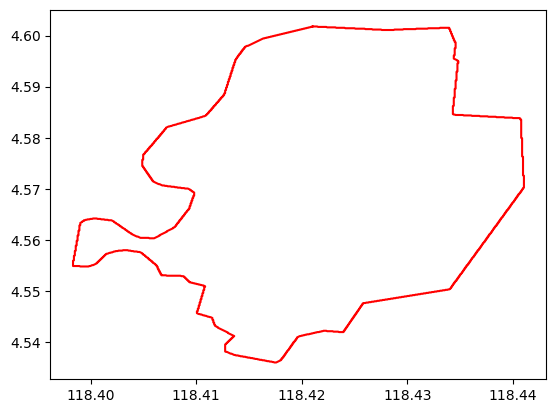

In [253]:
img_1 = cv2.cvtColor(img_ext, cv2.COLOR_RGB2HSV)
for i in range(len(img_1)):
    for j in range(len(img_1[0])):
        if i <= 80 and j <= 250:
            img_1[i][j] = [0,0,0]
        if img_1[i][j][1] < 100:
            img_1[i][j] = [0,0,0]
img_1 = cv2.cvtColor(img_1, cv2.COLOR_HSV2BGR)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
for i in range(50):
    for j in range(150):
        img_1[i][j] = 0

for i in range(1600, len(img_1)):
    for j in range(120):
        img_1[i][j] = 0

# # Binarize the image
_, binary = cv2.threshold(img_1, 100, 200, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
tlx, tly = (118.371, 4.606)
brx, bry = (118.465, 4.534)
h = abs(bry - tly)/len(img_1)
w = abs(brx - tlx)/len(img_1[0])
# Extract polygons from contours
polygons = set()
for contour in contours:
    # Convert contour to a list of (x, y) coordinates
    points = [(tlx + w* point[0][0], tly - h * point[0][1]) for point in contour]
    # Create a Shapely Polygon object
    # for point in points:
    #     plt.scatter(point[0], point[1])
    try:
        polygon = geometry.Polygon(points)
        polygons.add(polygon)
    except:
        continue
for i in polygons:
    x,y = i.exterior.xy
    plt.plot(x,y,c='red')
plt.show()

In [254]:
protected_areas[516] = geometry.MultiPolygon(polygons)

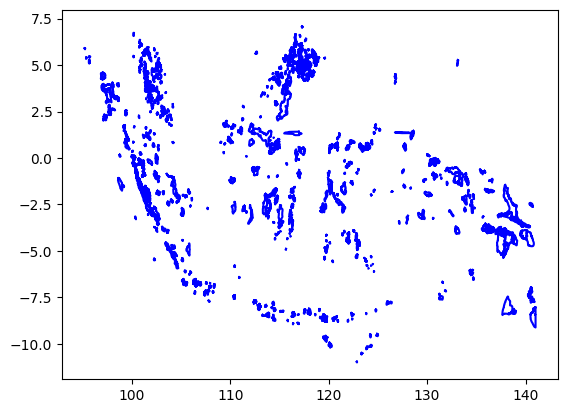

In [255]:
for i in protected_areas.keys():
    for polygon in protected_areas[i].geoms:
        x,y = polygon.exterior.xy
        plt.plot(x,y,c="blue")
plt.show()


In [256]:
import geopandas as gpd

In [258]:
data = {'geometry':[]}
for i in protected_areas.keys():
    data['geometry'].append(protected_areas[i])

gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")  # Assign a CRS (e.g., WGS84)
# Save to a shapefile
gdf.to_file("protected_areas.shp")
